     dim_name2         day   y_actual  y_predict  avg_reduce active_store  \
59          天津  2019-08-05  35.299523    37.4110    2.111477         1469   
119         济南  2019-08-05  52.728077    52.9600    0.231923         1243   
196         青岛  2019-08-05  42.120455    39.7085   -2.411955         1760   
283         上海  2019-08-05  65.571729    64.9851   -0.586629        23791   
312         南宁  2019-08-05  44.919330    41.3297   -3.589630         3223   
375         南京  2019-08-05  51.941350    50.2528   -1.688550        10520   
555         厦门  2019-08-05  29.728353    28.4933   -1.235053         1178   
435         合肥  2019-08-05  44.737611    42.6531   -2.084511         2805   
495         宁波  2019-08-05  43.905714    41.6340   -2.271714         3500   
811         无锡  2019-08-05  38.423294    38.7000    0.276706         2653   
615         广州  2019-08-05  72.883403    71.6029   -1.280503        17539   
675         海口  2019-08-05  42.351009    40.6656   -1.685409         3866   

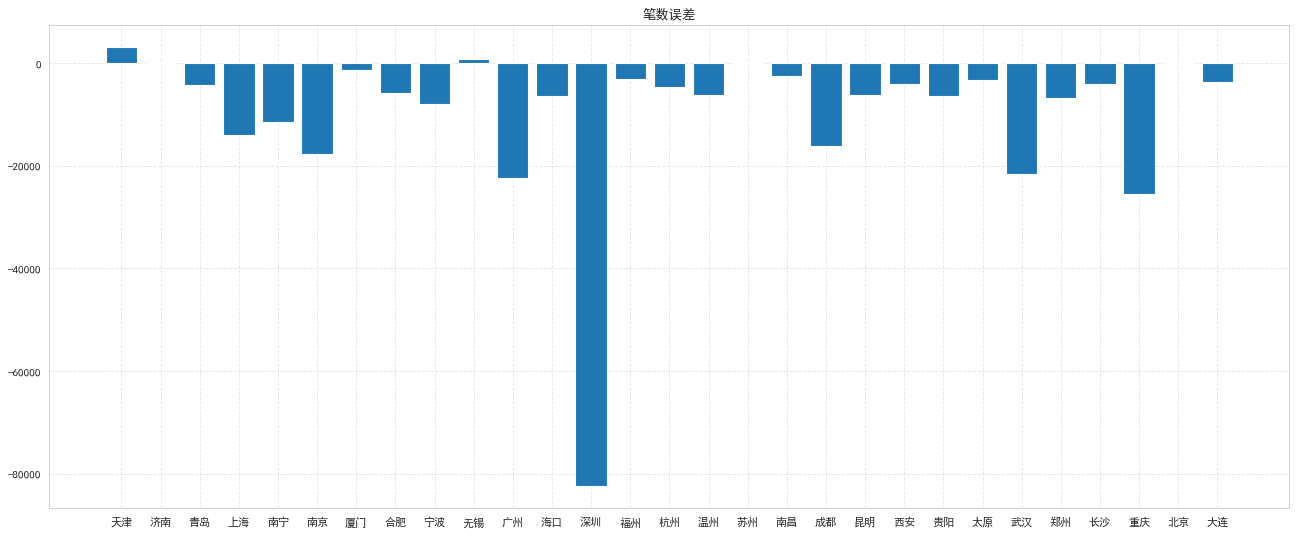

In [46]:
import pandas as pd
from pandas import DataFrame 
import numpy as np
import time
import datetime
from math import nan
from numpy import NaN
import matplotlib.pylab as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
transfer = StandardScaler()
end_day =datetime.datetime.now()+datetime.timedelta(days=-1)
delta=datetime.timedelta(days=-7)
start_day=end_day+delta

day_axis=pd.date_range(start_day.strftime('%Y-%m-%d'),end_day.strftime('%Y-%m-%d'))
start_day_str=start_day.strftime('%Y-%m-%d')
end_day_str=end_day.strftime('%Y-%m-%d')

def get_weekday(x):
    dateStr = x.split()[0]
    dateDT = datetime.datetime.strptime(dateStr,'%Y-%m-%d')
    week_day = dateDT.weekday()
    return week_day
def get_day(x):
    dateStr = x.split()[0]
    dateDT = datetime.datetime.strptime(dateStr,'%Y-%m-%d')
    return dateDT

def test(data_i):
    # data_i[['state1','state2','tem1','tem2','wind_power','humidity','星期','avg_cnt','active_store','day']] 
    
    #print(dim_name2)
    #index = data_i.index[data_i['state1'] == 0]
    #print(index)
    
    temp = data_i.iloc[:,0:1].astype(np.float64)
    temp = transfer.fit_transform(temp)
    data_i['state1'] = temp
    #list_ = data_i['state1'][index].values
    #list_ = list_[0]
    #print(list_)

    temp = data_i.iloc[:,1:2].astype(np.float64)
    temp = transfer.fit_transform(temp)
    data_i['state2'] = temp

    temp = data_i.iloc[:,2:3].astype(np.float64)
    temp = transfer.fit_transform(temp)
    data_i['tem1'] = temp

    temp = data_i.iloc[:,3:4].astype(np.float64)
    temp = transfer.fit_transform(temp)
    data_i['tem2'] = temp

    temp = data_i.iloc[:,5:6].astype(np.float64)
    temp = transfer.fit_transform(temp)
    data_i['humidity'] = temp
    
    week_data = pd.DataFrame()
    week_data = pd.get_dummies(data_i['星期'],prefix='week')
    data_i = pd.concat((data_i,week_data),axis=1)
            
    data_train=data_i[-data_i.day.isin([end_day_str])]    
    x_train = data_train.drop(['星期','avg_cnt','day','active_store'],axis=1)   
    y_train = (round(data_train['avg_cnt'],4)*10000).astype('int')
    model = KNeighborsClassifier()
    model.fit(x_train,y_train)   

  ##  x_test = data_i[data_i['day']== end_day_str][['state1','state2','tem1','tem2','wind_power','humidity','星期']]
    data_test =data_i[data_i['day']>=start_day] 
    x_test = pd.DataFrame()
    x_test = data_i[data_i['day']== end_day_str].drop(['星期','avg_cnt','day','active_store'],axis=1)
    x_test.loc[:,:1] = 0
    x_test.loc[:,1:2] = 0
    x_test.loc[:,2:3] = data_test['tem1'].mean()
    x_test.loc[:,3:4] = data_test['tem2'].mean()
    x_test.loc[:,5:6] = data_test['humidity'].mean()
    
    active_store = data_i[data_i['day']== end_day_str]['active_store']
    y_predict = model.predict(x_test)/10000
    y_actual = data_i[data_i['day']== end_day_str]['avg_cnt']
        
    avg_reduce = y_predict - y_actual
    cnt_reduct = round(avg_reduce * active_store)
    dataframe_temp = pd.DataFrame({'dim_name2':dim_name2,'day':end_day_str,'y_actual':y_actual,'y_predict':y_predict,'avg_reduce':avg_reduce,'active_store':active_store,'cnt_reduct':cnt_reduct})
    return dataframe_temp

if __name__ == '__main__':
    data = pd.read_csv('sqlresult_4071653.csv')
    data = data.dropna(axis=0,how='any') 
    data['星期'] = data.day.apply(get_weekday)
    data['day'] = data.day.apply(get_day)
    level4_name_dataframe=pd.DataFrame(np.array(data['level4_name'].unique()))
    level4_name=level4_name_dataframe.dropna(axis=0,how='any')    
    level4_list=[]
    result = pd.DataFrame(columns=['dim_name2','day', 'y_actual','y_predict','avg_reduce','active_store','cnt_reduct'])

    for i in level4_name.index:
        level4_list.append(level4_name.loc[i].values[0])

    for i in level4_list:
        dim_name2 = i
        data_abnormal = data[data['day']==end_day_str]   
        data_abnormal = data_abnormal[data_abnormal.level4_name==i]
        if data_abnormal['abnormal'].values == 0:
            data_i =data[data.level4_name==i]
            data_i = data_i[['state1','state2','tem1','tem2','wind_power','humidity','星期','avg_cnt','active_store','day']]   
            temp = test(data_i)
            result = result.append(temp)
    print(result)
    plt.rcParams['font.sans-serif'] = [u'SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    dim_name2 = result['dim_name2']
    cnt_reduct = result['cnt_reduct']
    plt.figure(figsize=(20,8),dpi=80)
    x_ticks = range(len(dim_name2))
    plt.bar(x_ticks,cnt_reduct)
    plt.xticks(x_ticks, dim_name2)
    plt.title("笔数误差")
    plt.grid(linestyle = '--', alpha = 0.5)
    plt.show()

F:\Anaconda\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
F:\Anaconda\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
F:\Anaconda\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warnin

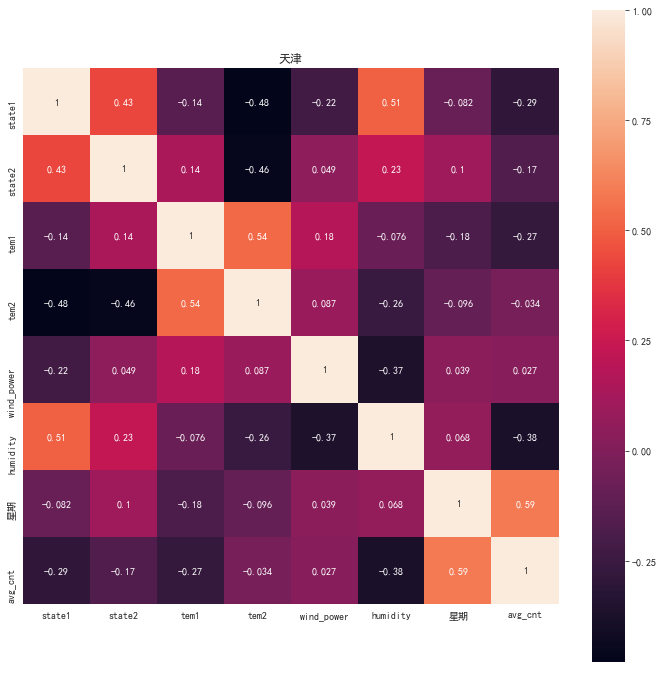

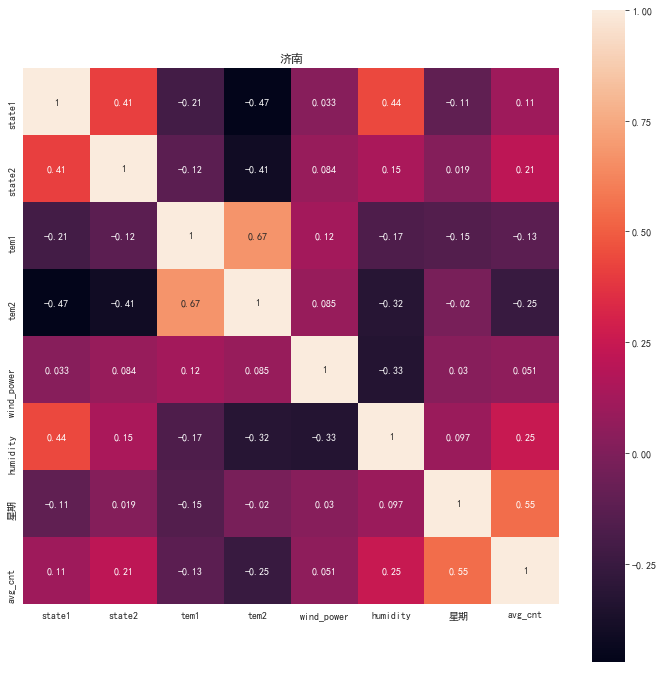

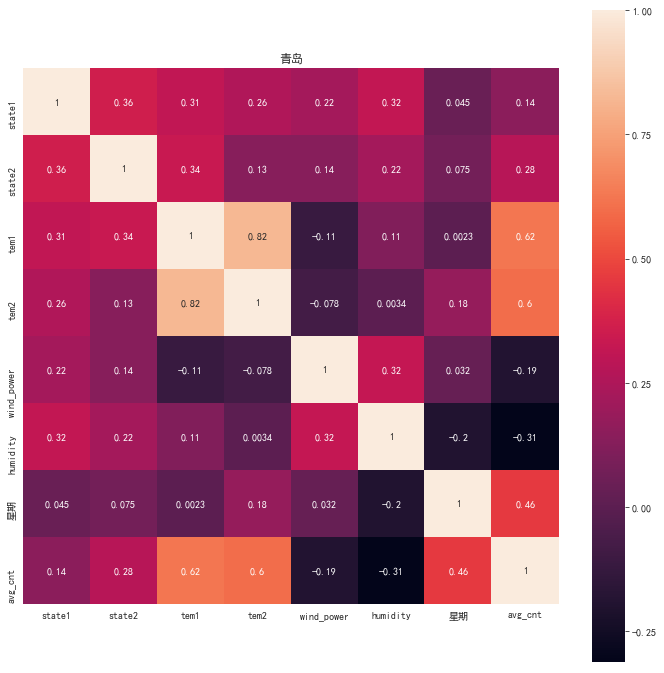

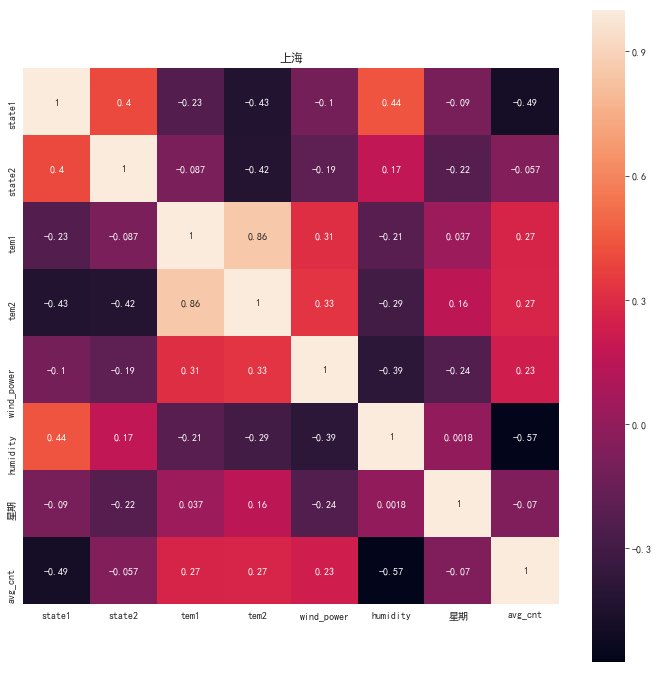

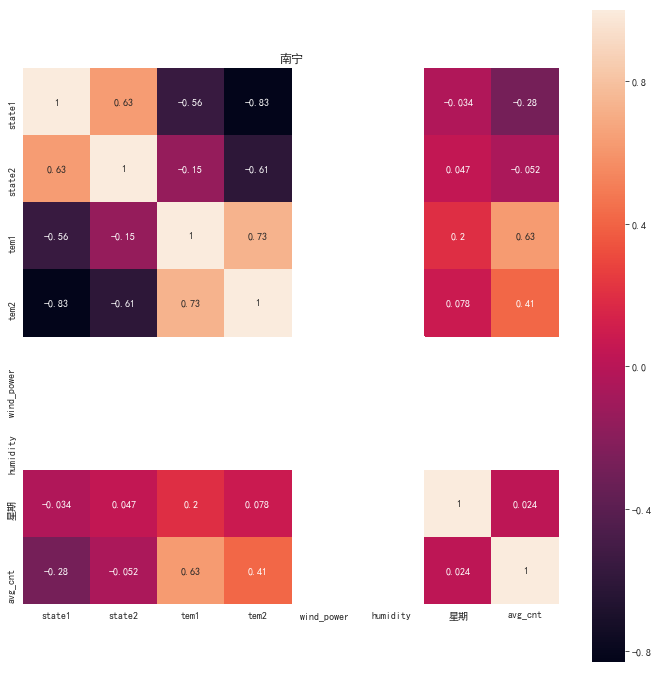

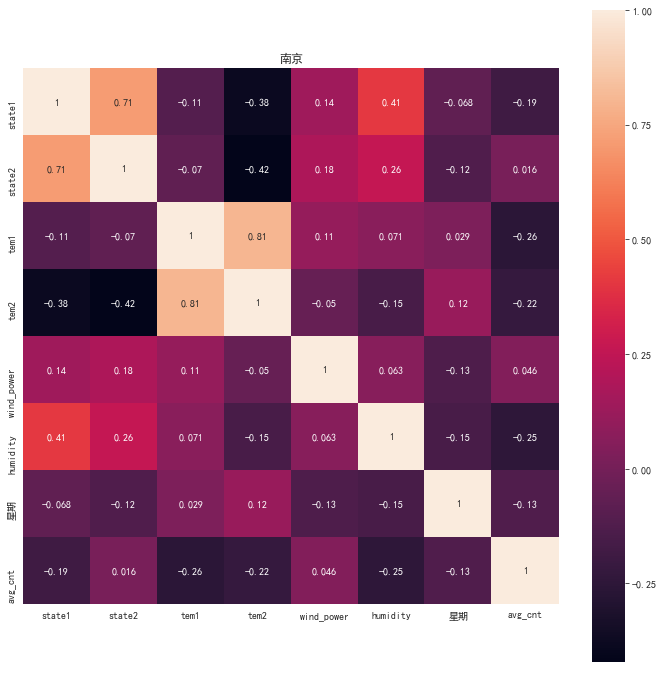

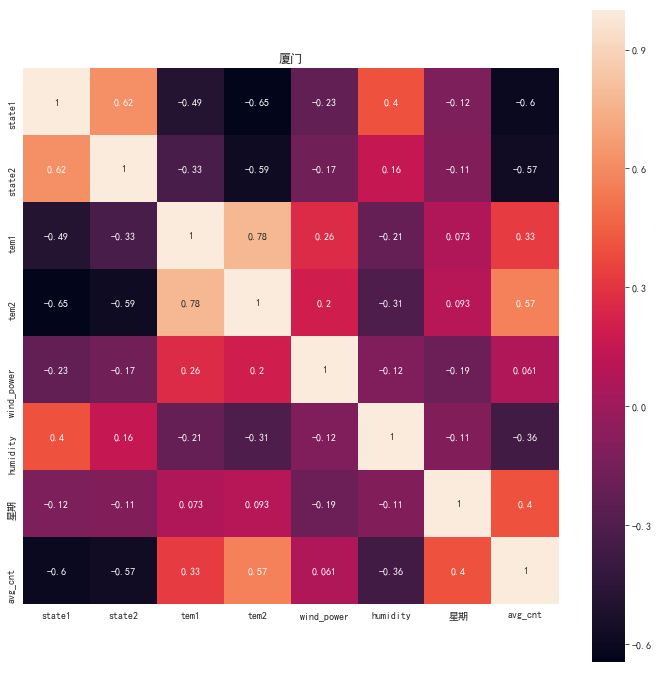

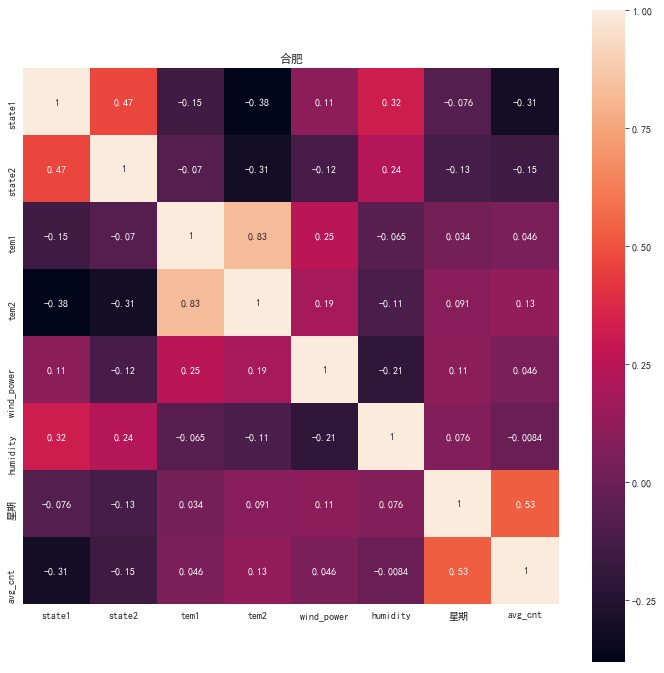

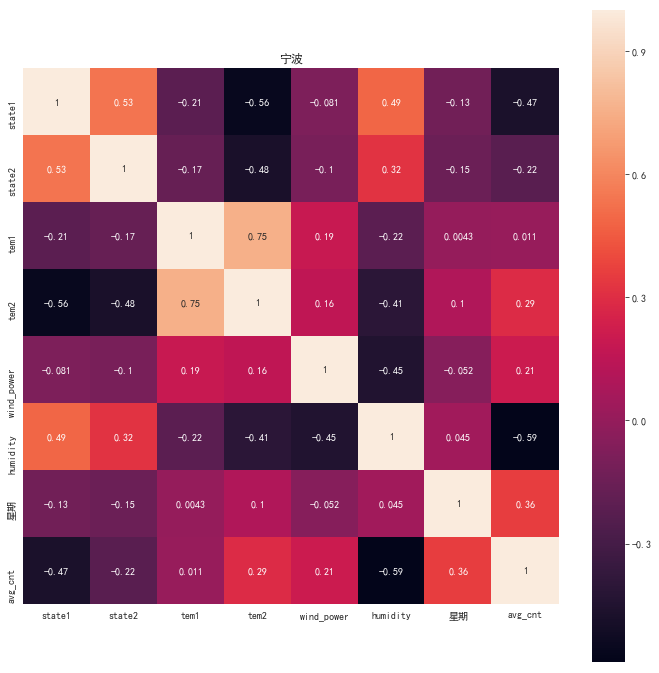

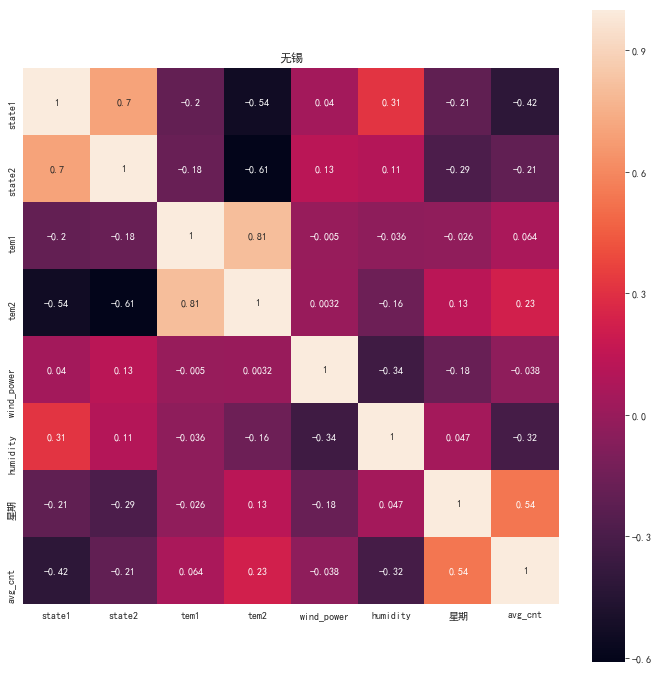

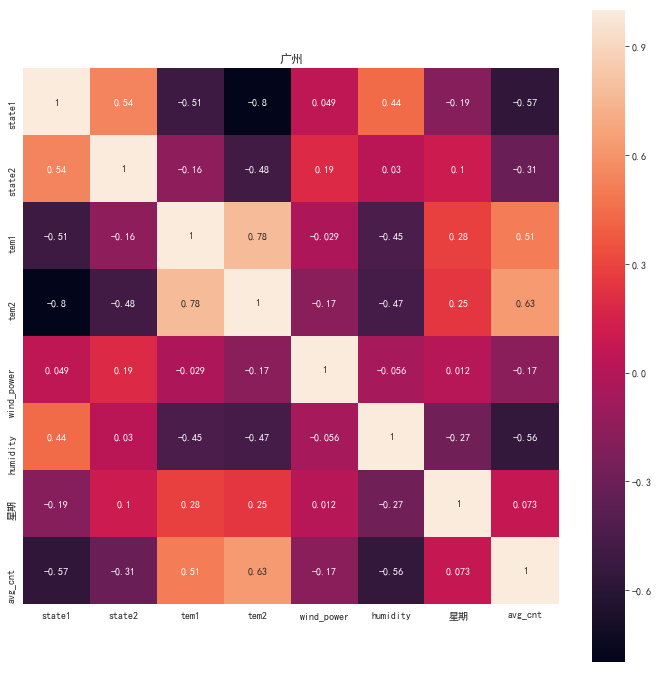

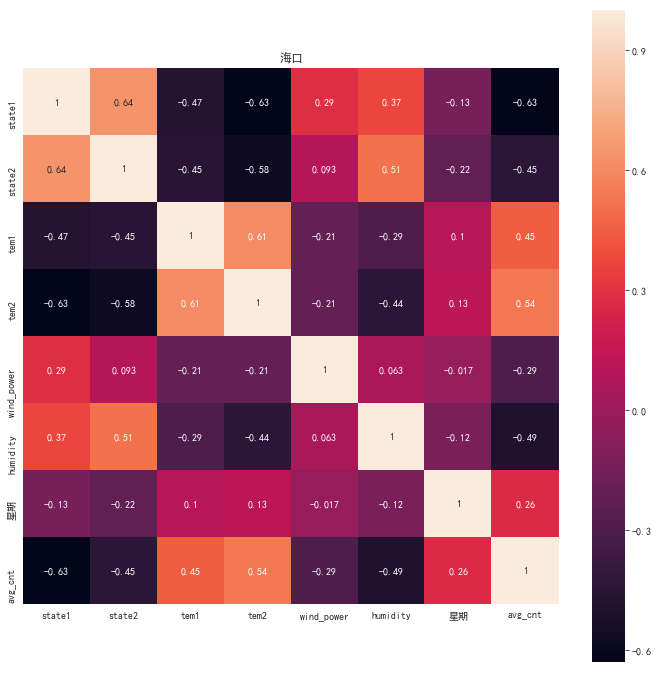

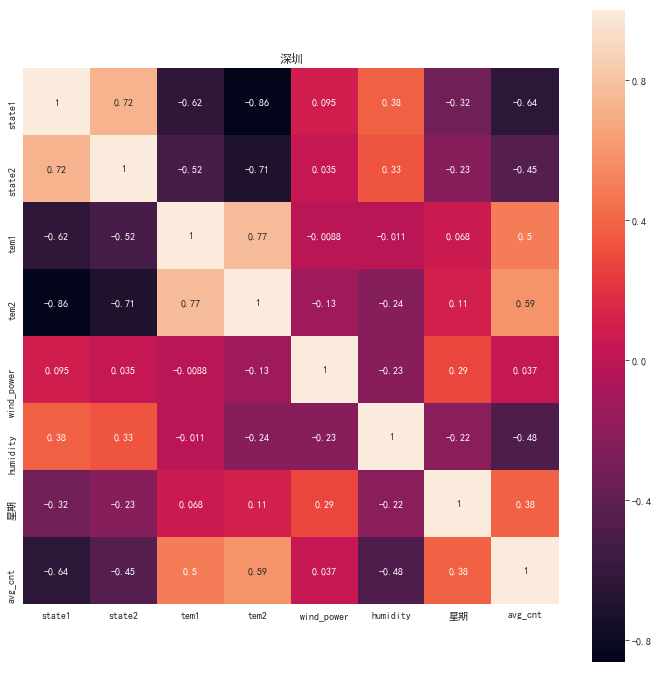

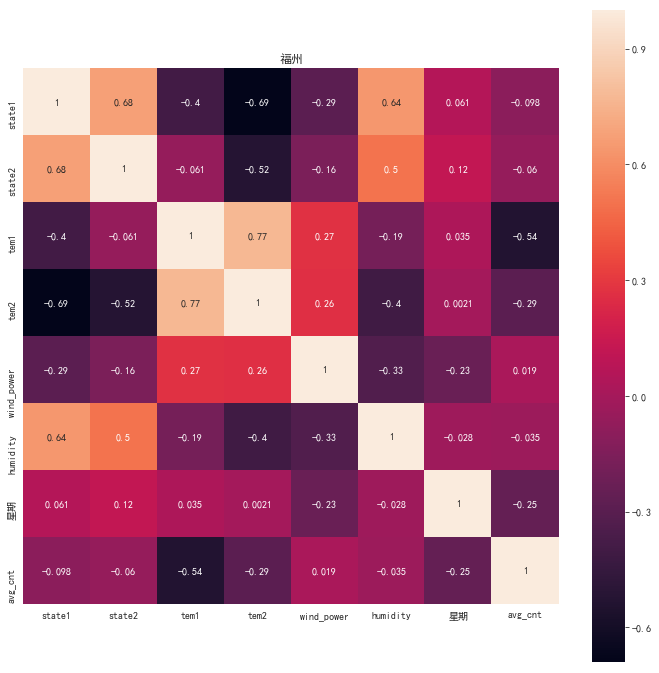

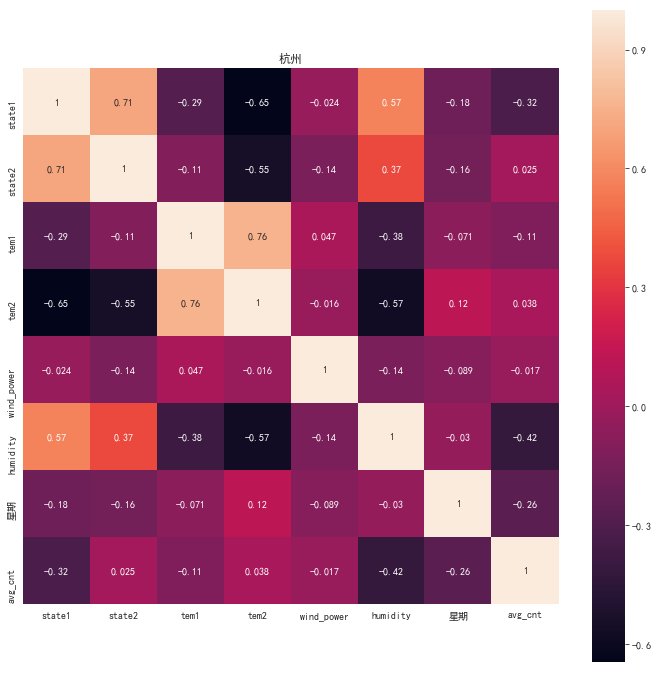

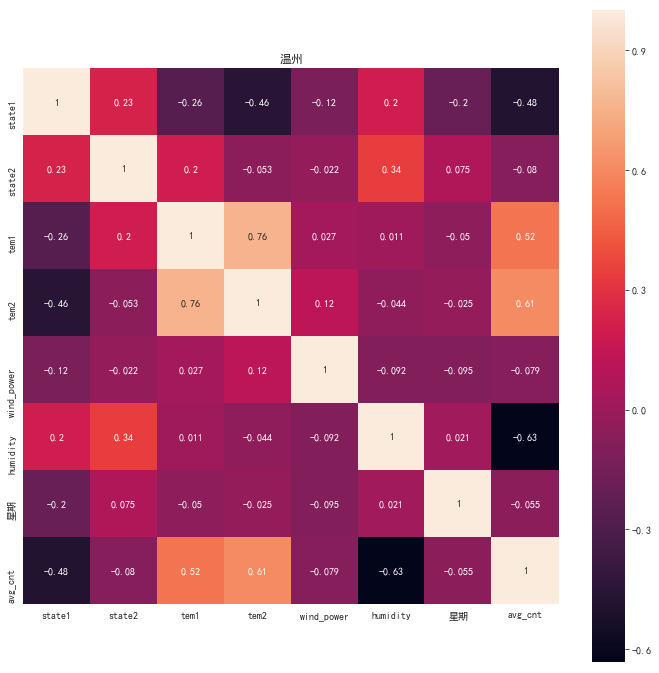

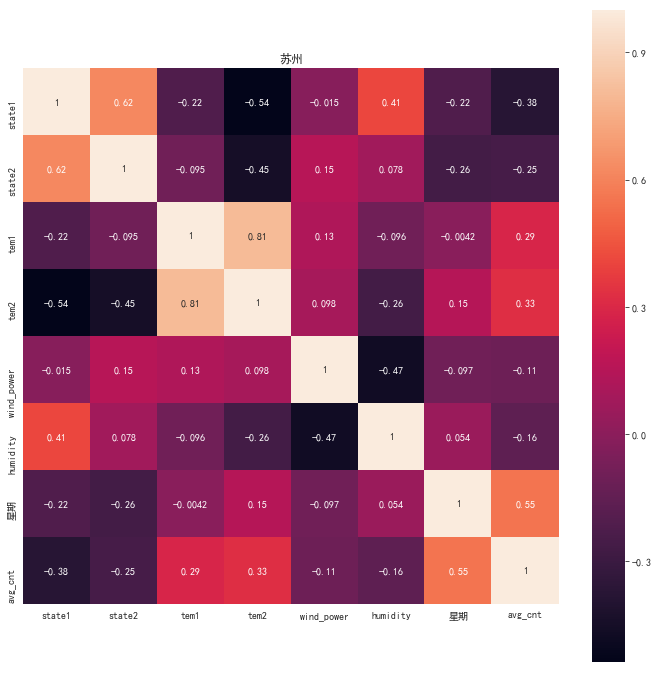

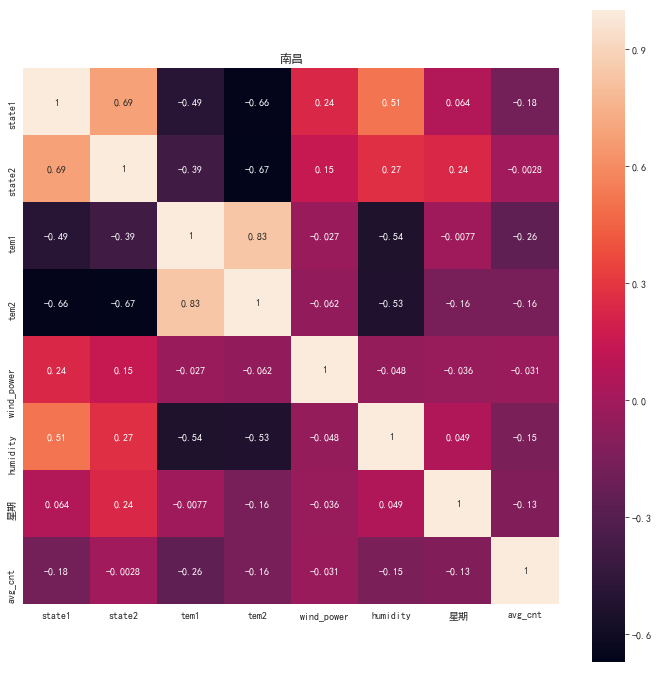

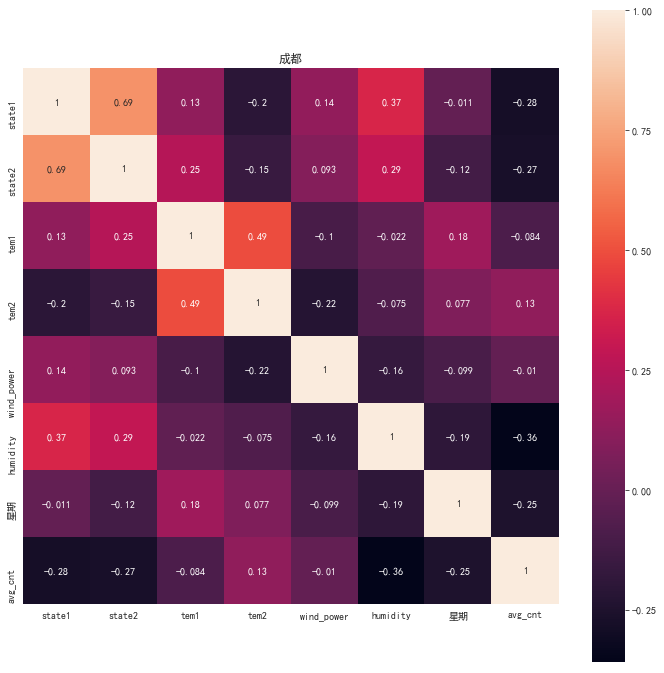

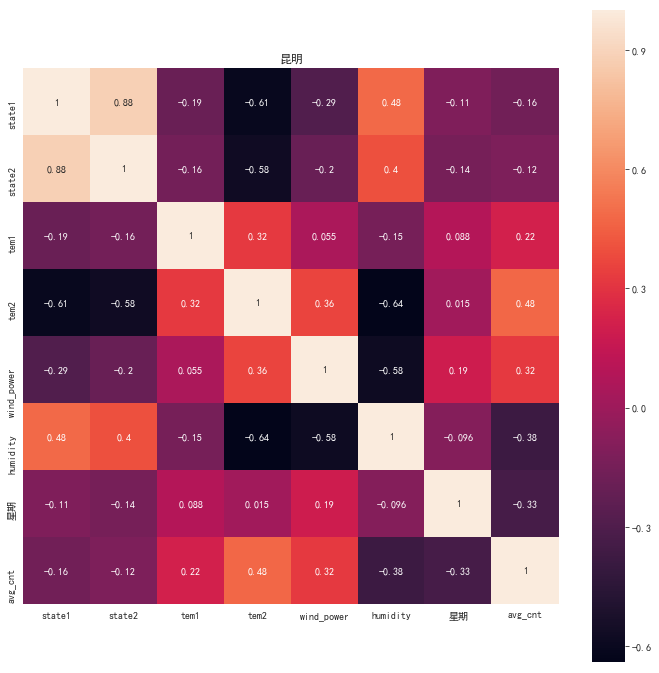

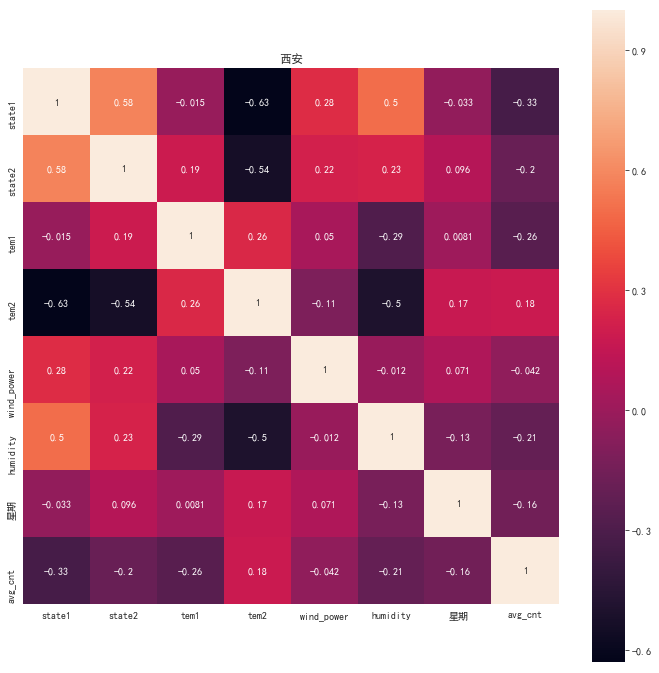

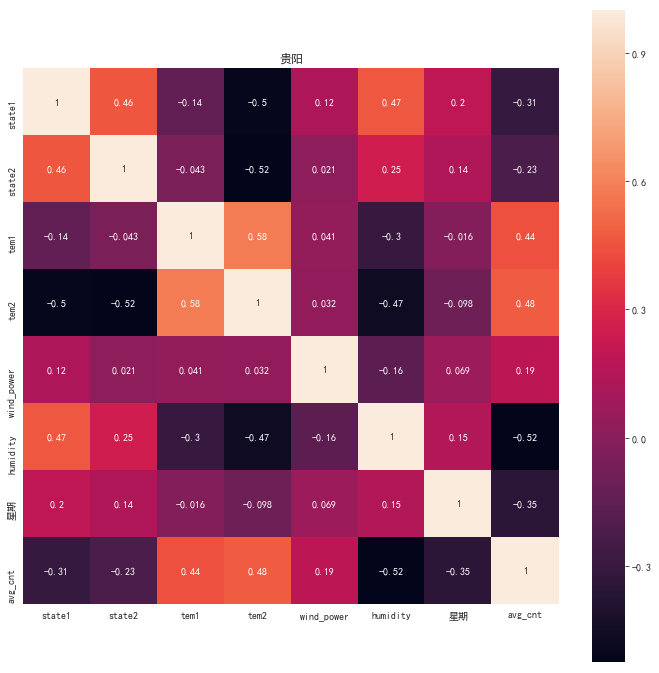

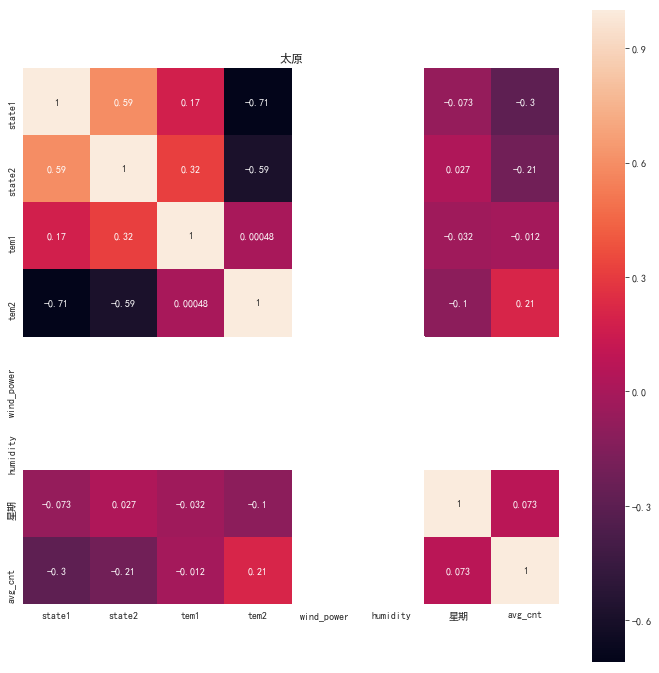

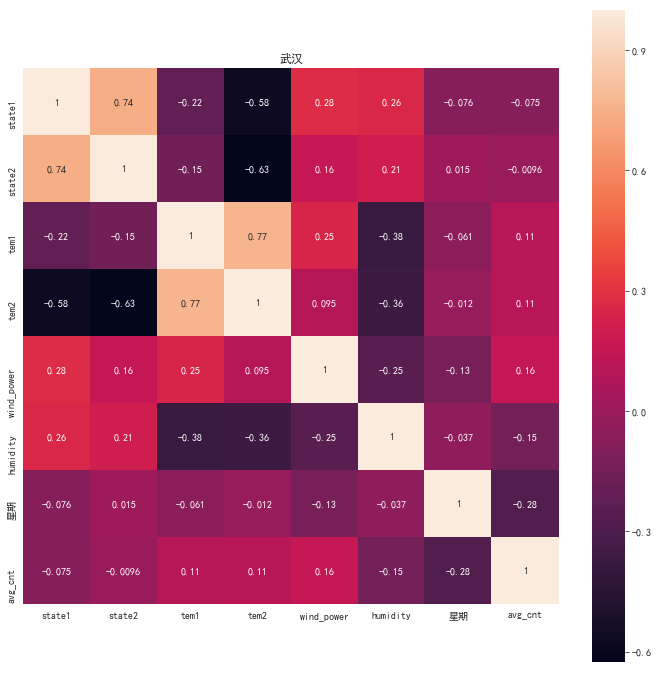

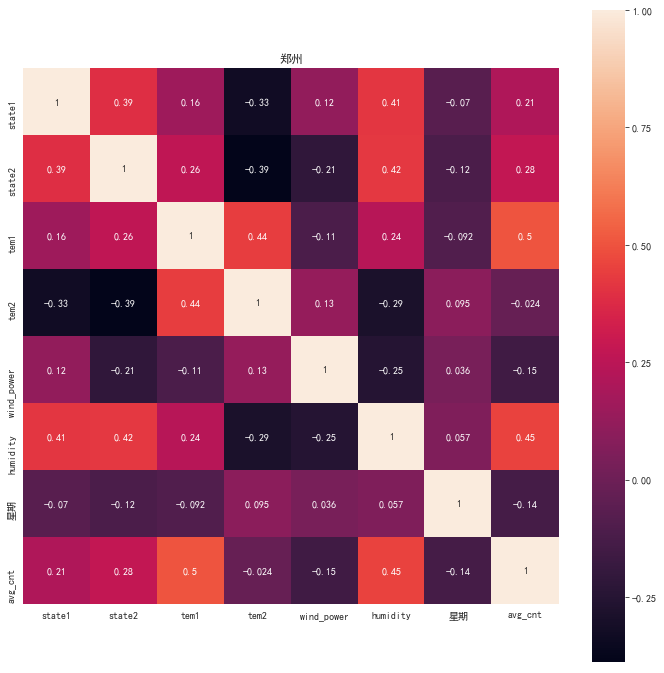

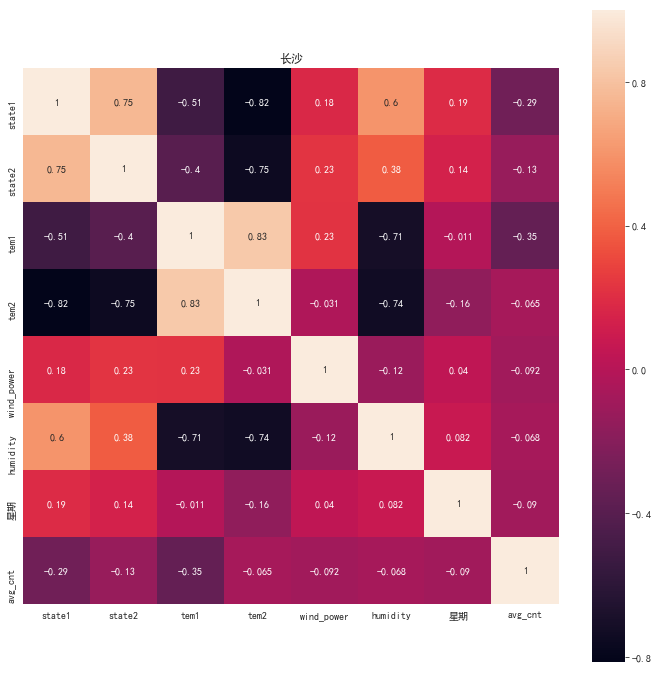

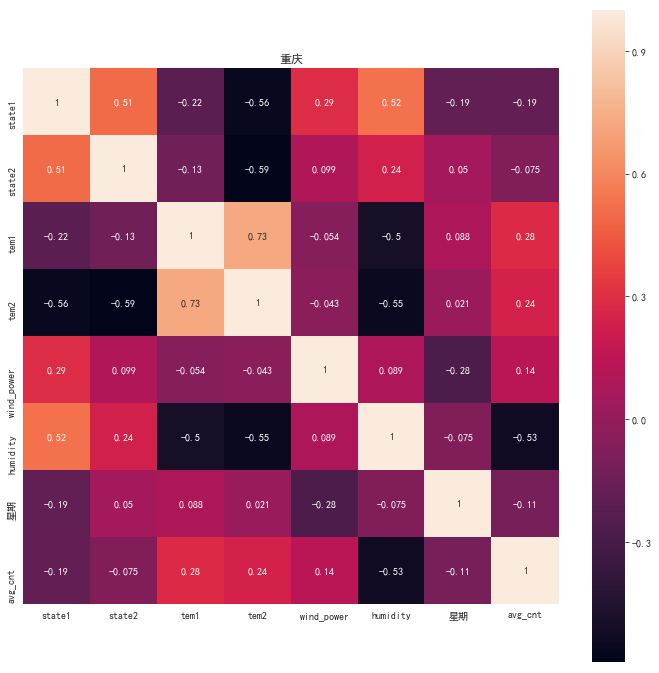

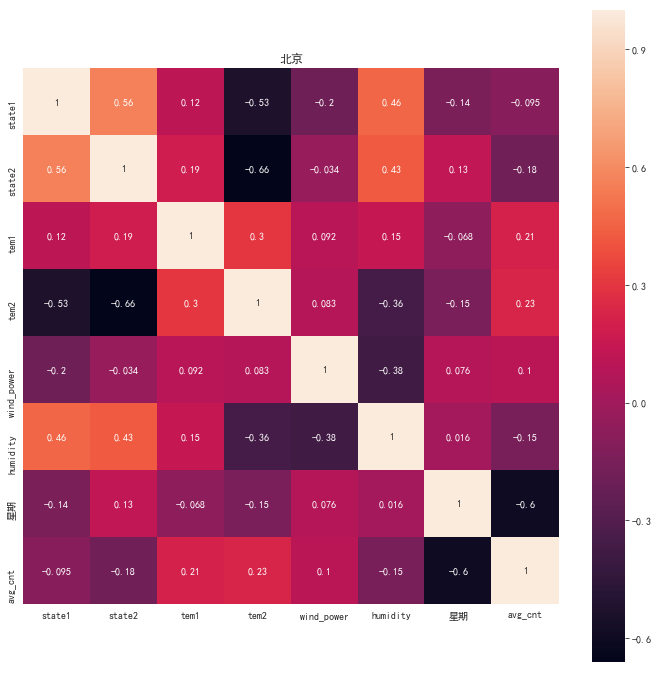

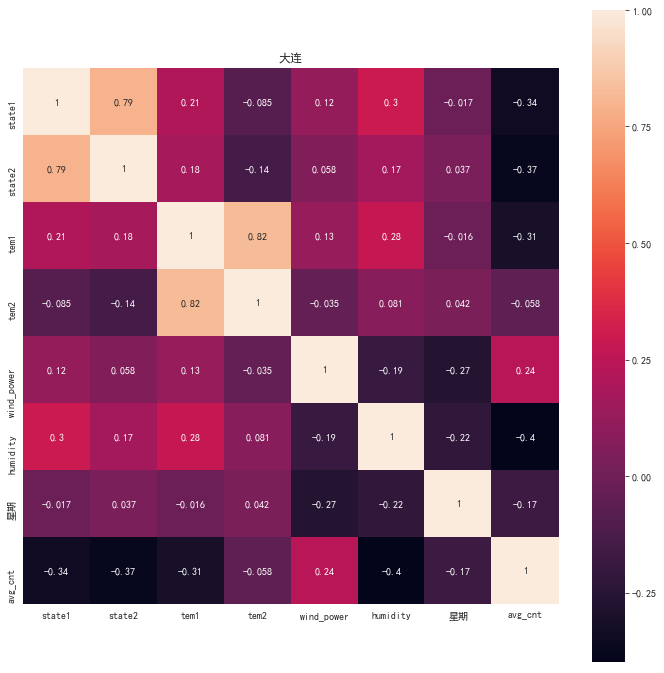

In [10]:
for i in level4_list:
    dim_name2 = i
    data_abnormal = data[data['day']==end_day_str]   
    data_abnormal = data_abnormal[data_abnormal.level4_name==i]
    if data_abnormal['abnormal'].values == 0:
        data_i =data[data.level4_name==i]
        data_i = data_i[['state1','state2','tem1','tem2','wind_power','humidity','星期','avg_cnt','active_store','day']]   
                
        temp = data_i.iloc[:,0:1].astype(np.float64)
        temp = transfer.fit_transform(temp)
        data_i['state1'] = temp

        temp = data_i.iloc[:,1:2].astype(np.float64)
        temp = transfer.fit_transform(temp)
        data_i['state2'] = temp

        temp = data_i.iloc[:,2:3].astype(np.float64)
        temp = transfer.fit_transform(temp)
        data_i['tem1'] = temp

        temp = data_i.iloc[:,3:4].astype(np.float64)
        temp = transfer.fit_transform(temp)
        data_i['tem2'] = temp

        temp = data_i.iloc[:,5:6].astype(np.float64)
        temp = transfer.fit_transform(temp)
        data_i['humidity'] = temp

        data_i = data_i[['state1','state2','tem1','tem2','wind_power','humidity','星期','avg_cnt']]           
        correlation = data_i.corr()
        sns.set_style('whitegrid',{'font.sans-serif':['simhei','Arial']})
        fig = plt.figure(figsize = (12,12))
        sns.heatmap(correlation,vmax = 1,square = True,annot=True)
        plt.title(dim_name2)


In [ ]:

correlation